<a href="https://colab.research.google.com/github/karlpolak/MDA-project/blob/classification/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**water stress level prediction**

In this notebook, we try to build a classification model to predict the water stress level of a country given some features of the country. 

Water stress definition: 
Freshwater withdrawal as a proportion of available freshwater resources. It is the ratio between total freshwater withdrawn by all major sectors and total renewable freshwater resources, after taking into account environmental flow requirements.

[SDG 6.4.2. Water Stress] = 100*[Total freshwater withdrawal]/([Total renewable water resources]-[Environmental Flow Requirements])

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Load and view aquastat data set

In [2]:
data=pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/preprocessed+data.csv')
data=data.set_index(['Area','Year'])

### Data Preprocessing and exploration


Distribution of water stress index

Right skewed

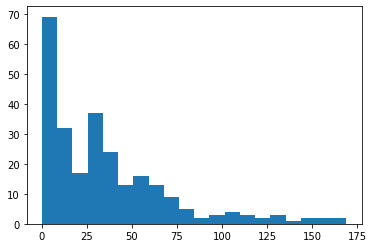

In [3]:
data['SDG 6.4.2. Water Stress'].hist(grid=False, bins=20)

Calculate the new variables, drop the old ones, divide the water stress indicator into 5 risk levels

In [4]:
data['Industry, value added (% GDP)']=data['Industry, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data['Services, value added (% GDP)']=data['Services, value added to GDP']/data['Gross Domestic Product (GDP)']*100
data.drop(['Services, value added to GDP','Industry, value added to GDP'],axis=1,inplace=True)
data['stressclass'] = pd.cut(data['SDG 6.4.2. Water Stress'],bins=[0,25,50,75,100,200],labels=['0','1','2','3','4'])

In [5]:
data.head()

Agricultural water withdrawal as % of total renewable water resources  \
Area        Year                                                                            
Afghanistan 1992.0                                          35.498101                       
            1997.0                                          31.427856                       
            2002.0                                          30.613807                       
            2007.0                                          30.613807                       
            2012.0                                          30.613807                       

                    Agriculture, value added (% GDP)  Average Temperature  \
Area        Year                                                            
Afghanistan 1992.0                         54.207106                12.61   
            1997.0                         62.416768                12.86   
            2002.0                         45.134344                13.91   
            2007.0                         35.265942                13.80   
            2012.0                         28.556142                13.25   

                    Environmental Flow Requirements  GDP per capita  \
Area        Year                                                      
Afghanistan 1992.0                            28.29      248.518890   
            1997.0                            28.29      164.092893   
            2002.0                            28.29      194.958382   
            2007.0                            28.29      389.985586   
            2012.0                            28.29      694.885618   

                    Long-term average annual precipitation in volume  \
Area        Year                                                       
Afghanistan 1992.0                                         213.48522   
            1997.0                                         213.48522   
            2002.0                                         213.48522   
            2007.0                                         213.48522   
            2012.0                                         213.48522   

                    MDG 7.5. Freshwater withdrawal as % of total renewable water resources  \
Area        Year                                                                             
Afghanistan 1992.0                                          35.910480                        
            1997.0                                          31.852952                        
            2002.0                                          31.045461                        
            2007.0                                          31.045461                        
            2012.0                                          31.045461                        

                    National Rainfall Index (NRI)  Population density  \
Area        Year                                                        
Afghanistan 1992.0                         304.98           22.187829   
            1997.0                         233.00           29.649735   
            2002.0                         185.00           34.618096   
            2007.0                         185.00           41.510486   
            2012.0                         185.00           47.730564   

                    SDG 6.4.1. Industrial Water Use Efficiency  ...  \
Area        Year                                                ...   
Afghanistan 1992.0                                   25.311413  ...   
            1997.0                                    9.091408  ...   
            2002.0                                   11.426285  ...   
            2007.0                                   20.815284  ...   
            2012.0                                   23.227115  ...   

                    SDG 6.4.1. Services Water Use Efficiency  \
Area        Year                                               
Afghanistan 1992.0          

The variables in the calculation of water stress level are dropped.

Predictors and response variable

In [6]:
X=data.iloc[:,0:23].drop(
    ['Environmental Flow Requirements',
     'Total renewable water resources per capita',
     'SDG 6.4.2. Water Stress',
     'MDG 7.5. Freshwater withdrawal as % of total renewable water resources',
     'stressclass'],axis=1)
y=data['stressclass']

Unbalanced data

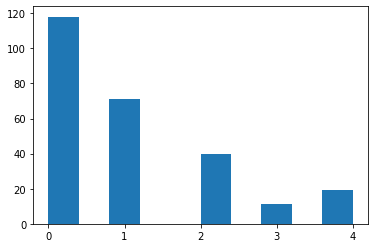

In [7]:
y.sort_values().hist(grid=False)

Synthetic Minority Oversampling Technique (SMOTE)

In [8]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

Split the data into train set and test set

In [9]:
X_train, X_test, y_train, y_test  = train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=0,shuffle=True,stratify=y_resampled)

## Classification

### Create pipeline framework

In [10]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('selector', SelectKBest(mutual_info_classif, k=5)),
                 ('classifier', LogisticRegression())])

### create search space


In [11]:
search_space = [{'selector__k': [5, 6, 7, 8, 9, 10]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators':[30, 50, 100],
                 'classifier__max_features': [1, 2, 3],
                 'classifier__min_samples_leaf':[1, 2, 3]},
                {'classifier': [LogisticRegression(max_iter=7000)]},
                {'classifier': [naive_bayes.GaussianNB()]},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__leaf_size': [5,10,15,30],
                 'classifier__n_neighbors': [5,10,15]}]

### model selection

In [12]:
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train)


best_pipe=clf.best_estimator_
features = best_pipe.named_steps['selector']

In [13]:
print("Best params:\n{}\n".format(clf.best_params_))
print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best estimator:\n{}\n".format(clf.best_estimator_))
print("Selected features:\n{}\n".format(X_train.columns[features.get_support()]))

Best params:
{'classifier': RandomForestClassifier(max_features=3, n_estimators=30), 'classifier__max_features': 3, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 30}

Best cross-validation score: 0.97
Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('selector',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x7fd2da69e4d0>)),
                ('classifier',
                 RandomForestClassifier(max_features=3, n_estimators=30))])

Selected features:
Index(['Agricultural water withdrawal as % of total renewable water resources',
       'Average Temperature',
       'Long-term average annual precipitation in volume',
       'National Rainfall Index (NRI)', 'Population density'],
      dtype='object')



The best 5 features to predict water stress level: 
'Agricultural water withdrawal as % of total renewable water resources',
       'Average Temperature',
       'Long-term average annual precipitation in volume',
       'National Rainfall Index (NRI)', 'Population density'
       
 Best classification algorithm: random forest classifer
 
 Temperature, precipitation, population and agricultural water withdrawal have an effect on water stress.

### Model validation

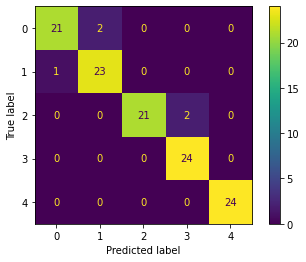

In [14]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [15]:
y_pred=clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9576271186440678

High accuracy, model fits well

### next step: VAR model

We build a model with which we can predict the water stress levels based on these predictors, 'Agricultural water withdrawal as % of total renewable water resources', 'Average Temperature', 'Long-term average annual precipitation in volume','National Rainfall Index (NRI)', 'Population density'. 
But we cannot forecast the future water stress levels since we don't know the future predictors. So, we turn to a time series model, Vector Autoregression model. 